# NLP processing

In [2]:
import pandas as pd
import regex, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aafo_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aafo_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aafo_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
plots = pd.read_csv('./data/plot_summaries.txt', sep='\t', header=None)
plots.columns = ['movie_id', 'plot_summary']

In [4]:
def text_preprocessing_pipeline(x, reg, stopwords, lemmatizer):
    return " ".join([w for w in 
            set(word_tokenize(lemmatizer(reg.sub('', x).lower().strip())))
            if w not in stopwords and w.isalpha()])

In [5]:
reg = regex.compile('[%s]' % regex.escape(string.punctuation))
stopw = list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer().lemmatize

In [6]:
plots.plot_summary = plots.plot_summary.apply(
    text_preprocessing_pipeline,
    reg = reg, stopwords = stopw, lemmatizer = lemmatizer)

In [7]:
plots.plot_summary

0        saxophonist realize relationship prejudices de...
1        past feast mellark careers defiance starcrosse...
2        good nandagopal task circumstances enters dead...
3        comes swindlers moose occupied past confront l...
4        running coffin enjoying experts campers wooden...
                               ...                        
42298    film young muslim malayalam school poetry stat...
42299    amusement comes dangerous leos flashes watches...
42300    perry focuses way realized musician aspiring d...
42301    minis fruit comes customers boarding realises ...
42302    formed assembled nobody fund binoculars joins ...
Name: plot_summary, Length: 42303, dtype: object

In [8]:
# plots.to_csv('./data/plot_summaries_preprocessed.csv', index = False)

# NLP processed + Movie_metadata join

In [65]:
import pandas as pd
import numpy as np
from sklearn.decomposition import FactorAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

In [137]:
plots = pd.read_csv('./data/plot_summaries_preprocessed.csv')
plots.columns = ['movie_id', 'plot_summary']

In [331]:
fact = 5
fa = FactorAnalysis(fact)
vectorizer = TfidfVectorizer(max_features = 20000)
fa.fit(vectorizer.fit_transform(plots.plot_summary).toarray())

FactorAnalysis(n_components=5)

In [332]:
factorWeights = pd.DataFrame(fa.components_.T, index = list(vectorizer.vocabulary_.keys()),
                                columns = [x+1 for x in range(0, fact)])
factorWeights.head()

,1,2,3,4,5
saxophonist,0.000053,-0.000017,-0.000038,0.000043,-0.000032
realize,0.000059,-0.000021,-0.000037,0.000096,-0.000045
relationship,0.000049,-0.000045,-0.000002,0.000042,0.000025
prejudices,-0.000023,-0.000123,-0.000116,-0.000187,0.000057
despite,0.000014,-0.000020,-0.000046,-0.000007,-0.000023


In [333]:
categories = {}
number_of_words = 100
for f in range(1,fact+1):
  temp = factorWeights[f].abs().sort_values(ascending = False)[:number_of_words]
  categories[str(f)] = ", ".join(list(temp.index))

In [334]:
factorAnalysisResults = pd.Series(categories)

In [335]:
for x in range(len(factorAnalysisResults)):
    print(f"Factor {x+1}")
    print(factorAnalysisResults[x])

Factor 1
indiscretion, whose, doe, instigates, much, conclusions, luggage, looming, debilitating, scooby, financed, captivated, jess, christianity, congratulate, flooded, sweden, consist, embraced, surmise, simms, roma, seizure, professors, impersonate, modest, emil, vindicated, fact, enhanced, keen, sham, unity, ensemble, allegations, ranchers, detection, growth, binge, employs, young, krishnas, ganga, washedup, seetha, beatles, stupor, cobra, crawford, fuck, madras, blackjack, angelina, blindness, holloway, arabs, creeping, operator, spot, create, responded, mousehole, hindi, dungeon, table, manipulative, revolve, mixed, ina, missionaries, fixes, pearl, darkness, witches, shootings, mist, confrontation, accompanies, uncover, harvey, energetic, paycheck, alimony, conjoined, frustration, devs, compensation, emma, helpless, malik, civilisation, returned, hamburger, bidding, respectable, inlaws, marsha, racketeer, vessels, civic
Factor 2
tormentors, strauss, snapping, clings, coaxed, cul

In [336]:
# with open("./data/factors.txt", "w") as fp:
#     for x in range(len(factorAnalysisResults)):
#         print(f"Factor {x+1}", file = fp)
#         print(factorAnalysisResults[x], file = fp)

In [337]:
def get_factor(plot):
    occurrences = dict(zip(factorAnalysisResults.index, [0]*len(factorAnalysisResults.index)))
    for word in plot.split():
        for x in occurrences:
            if word in factorAnalysisResults[x]:
                occurrences[x]+=1

    return max(occurrences, key = occurrences.get)

In [338]:
plots["factor"] = plots.plot_summary.apply(get_factor).astype(int)

In [339]:
plots

,movie_id,plot_summary,factor
0,23890098,saxophonist realize relationship prejudices de...,2
1,31186339,past feast mellark careers defiance starcrosse...,4
2,20663735,good nandagopal task circumstances enters dead...,1
3,2231378,comes swindlers moose occupied past confront l...,2
4,595909,running coffin enjoying experts campers wooden...,1
...,...,...,...
42298,34808485,film young muslim malayalam school poetry stat...,1
42299,1096473,amusement comes dangerous leos flashes watches...,2
42300,35102018,perry focuses way realized musician aspiring d...,4
42301,8628195,minis fruit comes customers boarding realises ...,1


In [340]:
movie_metadata = pd.read_csv('./data/movie_metadata_clean.csv').set_index('movie_id')
movie_metadata_factor = pd.merge(movie_metadata, plots.set_index('movie_id')["factor"], right_index = True, left_index = True)

<ipython-input-340-10b17e994461>:1: DtypeWarning: Columns (15,16,17,18,19,20,29,30,31,32,33,34,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('./data/movie_metadata_clean.csv').set_index('movie_id')


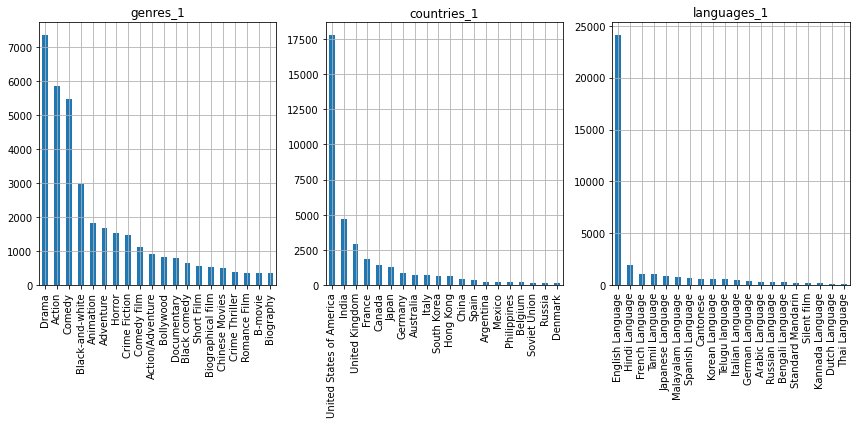

In [341]:
fig, ax = plt.subplots(1, 3, figsize =(12,6))
ax = ax.flatten()
for i, col in enumerate(["genres_1", "countries_1", "languages_1"]):
    movie_metadata_factor[col].value_counts()[:20].plot.bar(ax = ax[i])
    ax[i].set(title = col)
    ax[i].grid()

plt.tight_layout()

plt.savefig('./figs/general_proportions.jpeg')
plt.show()

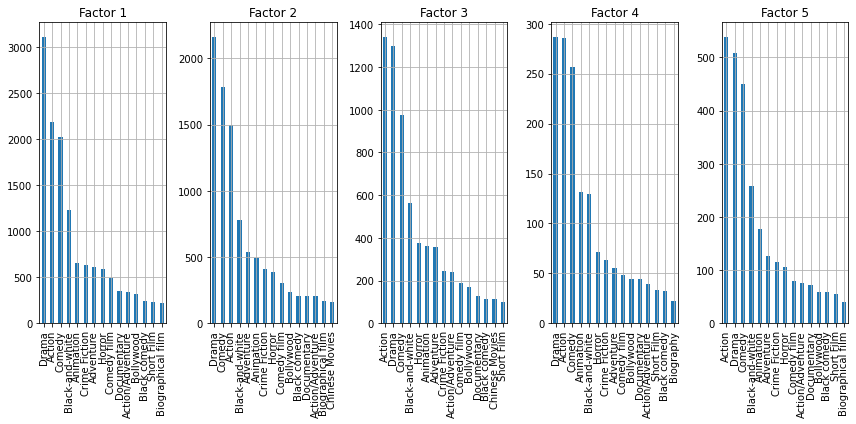

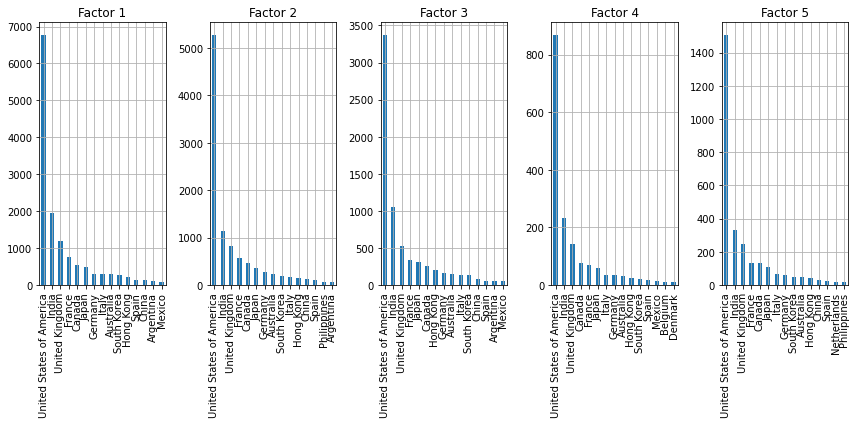

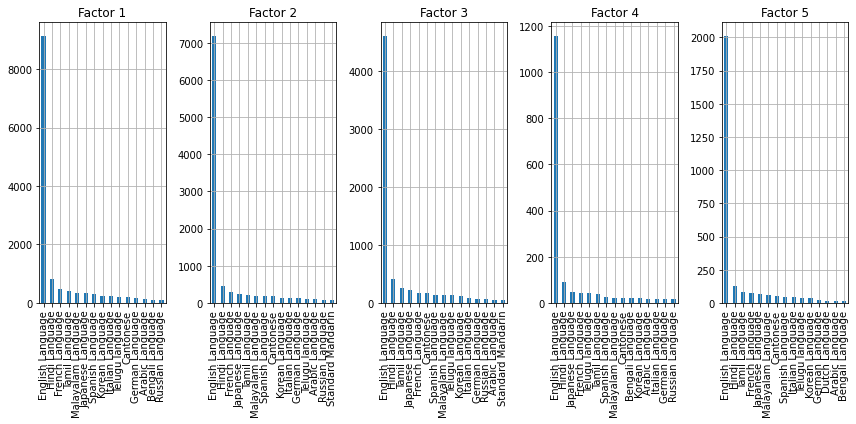

In [346]:
ncol = 5
n_vals = 15
nrow = plots.factor.max() // ncol if plots.factor.max() % ncol == 0 else plots.factor.max() // ncol +ncol

for col in ["genres_1", "countries_1", "languages_1"]:

    fig, ax = plt.subplots(nrow, ncol, figsize =(12,6))
    ax = ax.flatten()
    
    dfs = []
    for factor, df in movie_metadata_factor.groupby('factor')[col]:
        dfs.append(df.value_counts().sort_values(ascending = False)[:n_vals])
    
    
    for i, temp_df in enumerate(dfs):
        
        to_plot = temp_df.index
        
        # all_index = [dfs[k].index.tolist() for k in range(len(dfs)) if k!= i]
        
        # indexes = []
        # for ls in all_index:
        #     indexes += ls
        
        # to_plot = [x for x in temp_df.index if x not in indexes]
        
        try:
            temp_df[to_plot].plot.bar(ax = ax[i])
            ax[i].grid()
            ax[i].set(title = f"Factor {i+1}")
        except:
            print(f"{col}: change number of vals: {n_vals}, factor {i} wont plot")


    plt.tight_layout()

    plt.savefig(f'./figs/{col}_by_factor_5.jpeg')
    plt.show()